# SVM Implementation with CVXOPT

Oscar Contreras Carrasco

<p>Hi everyone! I really hope you enjoy this exercise where we will get a chance to implement a soft-margin SVM. For simplicity and for illustration purposes, I have used a toy dataset. However, I highly encourage you to try with other binary datasets. And let me know what you find!</p>
<p>
Let us first remember the general optimisation problem we try to address. It is given by:
</p>
<p>
    \begin{equation*}
    \large {
      {\arg \max_{\mathbf w,b}}
        \left\{
        \frac {1} 
             {\left\| \mathbf w \right\|}
             \min_n \left[y_n(\mathbf{w^\intercal}\mathbf x_n+b)\right]
            \right\}
    }
    \end{equation*}
</p>
<p>
    Therefore, the primal problem for SVM can be expressed as a function of a set of Lagrange multipliers α:
</p>
<p>
    \begin{equation*}
    \large {
      L(\mathbf w, b, \mathbf \alpha)=\frac 1 2 
      {\left\| \mathbf w \right\|}^2-\sum_{n=1}^N\alpha_n
       \left\{y_n(\mathbf{w^\intercal}\mathbf x_n+b-1)\right\}
    }
    \end{equation*}
</p>
<p>
    A much more convenient expression for this is given by the dual problem, whose optimization objective is:
</p>
<p>
    \begin{equation*}
    \large {
      L(\mathbf \alpha)=\sum_{n=1}^N \alpha_n-\frac 1 2 \sum_{m=1}^N\sum_{n=1}^N\alpha_m\alpha_n y_m y_n k(\mathbf x_m, \mathbf x_n)
    }
    \end{equation*}
</p>
<p>
    Sujeto a:
</p>
<p>
    \begin{equation*}
    \large {
      \alpha_n \ge 0,\quad \sum_{n=1}^N \alpha_n y_n = 0
    }
    \end{equation*}
</p>
<p>
    However, this version of the dual problem can only deal with scenarios where the data is completely separable, which is far from real. However, if we modify the restriction to include a tolerance variable $C$, we can cater for these cases. Therefore, the restrictions become:
</p>
<p>
    \begin{equation*}
    \large {
       0 \le \alpha_n \le C,\quad \sum_{n=1}^N \alpha_n y_n = 0
    }
    \end{equation*}
</p>
<p>
    Furthermore, $k$ in the dual problem is a kernel function we use to account for scenarios where the data is not completely separable. Two of the most popular kernels used are the linear kernel and the RBF, respectively given by:
</p>
<p>
    \begin{equation*}
    \large {
       k(\mathbf x, \mathbf x')=\mathbf{x^\intercal}\mathbf x',\quad k(\mathbf x, \mathbf x')=\exp\left(-\gamma\|{\mathbf x-\mathbf x'}\|^2\right)
    }
    \end{equation*}
</p>
<p>
    Let's now begin with the exercise. It will be divided into two parts. First, we use a soft-margin SVM on a linearly separable dataset and then, we use a RBF kernel to work on a non-linearly separable dataset.
</p>
The libraries we will use for this exercise are the following:

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from cvxopt import matrix, solvers
from sklearn.svm import SVC

parameters = {}
KERNEL_LINEAR = 1
KERNEL_RBF = 2

DATASET_LINEARLY_SEPARABLE = 1
DATASET_CIRCULAR = 2

Now we will generate a toy dataset containing 2000 two-dimensional points. This function receives a __dataset__ argument whose possible values are:

- DATASET_LINEARLY_SEPARABLE: Generate a linearly separable dataset
- DATASET_CIRCULAR: Generate a non-linearly separable dataset that is distributed as a circle around the centre.

In [0]:
def generate_data(dataset):
    n = 2000
    X = np.random.rand(n, 2)
    y = np.zeros((n,))
    noise = np.random.uniform(-0.05, 0.05, n)
    
    if dataset == DATASET_LINEARLY_SEPARABLE:
        for i in range(n):
            x1 = X[i][0]
            x2 = X[i][1] + noise[i]
            y[i] = 1.0 if x2 <= 1.0 * x1 else -1.0
    else:
        r = 0.3
        centre = np.array([0.5, 0.5])

        for i in range(n):
            dist = np.linalg.norm(X[i] - centre) + noise[i]
            y[i] = 1.0 if dist <= r else -1.0
        
    parameters['X'] = X
    parameters['y'] = y
    
    return X, y
        

Let's now visualise our dataset! In this first part we will work with a non-linearly separable dataset:

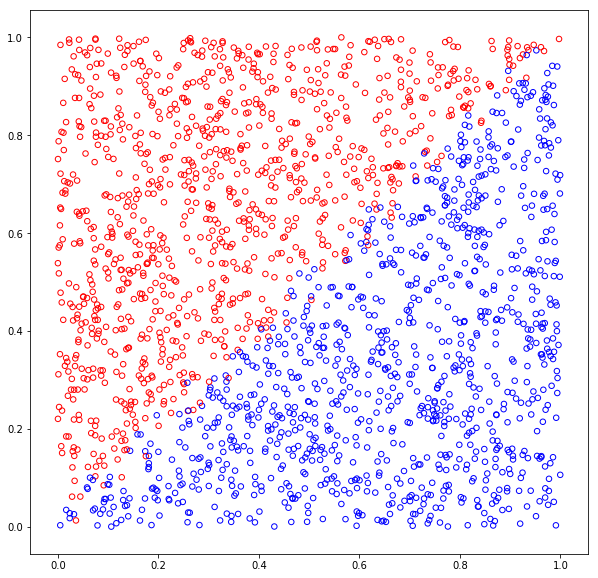

In [3]:
X, y = generate_data(DATASET_LINEARLY_SEPARABLE)
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.scatter(X[:,0], X[:,1], edgecolors=['red' if y_i == -1 else 'blue' for y_i in y], facecolors='none', s=30)
plt.show()

The following function allows us to calculate the value of the desired kernel. There are two options:
- Linear kernel
- RBF 
And these are given by:
<p>
    \begin{equation*}
      \large {
        k(\mathbf x,\mathbf y)=\mathbf {x^\intercal y} \\
        k(\mathbf x,\mathbf y)=\exp\left(-\gamma\|{\mathbf x-\mathbf y}\|^2\right)
      }
    \end{equation*}
</p>
<p>
    Where <b>K</b> is the Kernel or Gram matrix.
</p>

In [0]:
def gram_matrix(X, Y, kernel_type, gamma=0.5):
    K = np.zeros((X.shape[0], Y.shape[0]))
    
    if kernel_type == KERNEL_LINEAR:
        for i, x in enumerate(X):
            for j, y in enumerate(Y):
                K[i, j] = np.dot(x.T, y)
                
    elif kernel_type == KERNEL_RBF:
        for i, x in enumerate(X):
            for j, y in enumerate(Y):
                K[i, j] = np.exp(-gamma * np.linalg.norm(x - y) ** 2)
        
    return K

<p>We are now going to train our SVM using CVXOPT, which is a popular optimization library. However, before using this library, we need to do two things: We must turn the dual problem into a minimization objective and then convert everything to matrix form. Let's express the dual problem as a minimization by changing the sign of L:</p>
<p>
    \begin{equation*}
    \Large {
      L_{\min}(\mathbf \alpha)=\frac 1 2 \sum_{m=1}^N\sum_{n=1}^N\alpha_m\alpha_n y_m y_n k(\mathbf x_m, \mathbf x_n)-\sum_{n=1}^N \alpha_n
    }
    \end{equation*}
</p>
<p>
    And now let's turn this, as well as the restrictions, into matrices:
</p>
<p>
    \begin{equation*}
    \Large {
      L_{\min}(\mathbf \alpha)=\frac 1 2 \alpha^T\mathbf H\alpha-1^T\alpha
    }
    \end{equation*}
</p>
<p>
    The restrictions, expressed in matrix form, are the following:
</p>
<p>
    \begin{equation*}
      \Large { 
        -\alpha_i\le 0 \\
        \alpha_i\le C \\
        \mathbf {y^\intercal}\alpha=0
      }
    \end{equation*}
</p>
<p>
    In order to configure our quadratic programming problem with CVXOPT, we will need the following matrices:
</p>
<p>
    \begin{equation*}
      \Large {
        P_{N\times N} = H_{N\times N} = (\mathbf y \mathbf {y^\intercal}) * K(\mathbf X, \mathbf X) \\
        q_{N\times 1} = -\begin{pmatrix}
            1\\
            1\\
            1\\
            \vdots\\
            \vdots\\
            1
          \end{pmatrix} \\
    G_{2N\times N}=\begin{pmatrix}
          -1 & 0 & 0    &   \vdots  &     \\
          0 & -1 &     &     &     \\
          0  &   & -1   &     &     \\
          0  &   &     & -1   &  \\
          \vdots  &   &     &     & -1 \\
          1 & 0 & 0    &   \vdots  &     \\
          0 & 1 &     &     &     \\
          0  &   & 1   &     &     \\
          0  &   &     & 1   &  \\
          \vdots  &   &     &     & 1 
      \end{pmatrix} \\
        h_{2N\times 1}=\begin{pmatrix}
                0\\
                0\\
                0\\
                \vdots\\
                \vdots\\
                C\\
                C\\
                C\\
                \vdots\\
                \vdots\\
              \end{pmatrix}\\
      A_{N\times 1}=\mathbf y\\
      b = [0]
    }
    \end{equation*}
</p>
<p>
    Where <b>N</b> is the number of points in our dataset and <b>K</b> is the gram matrix, which we obtained in the gram_matrix function we defined previously. With these considerations, the training function will be:
</p>

In [0]:
def train_svm(kernel):
    C = 100
    n, k = X.shape
    
    y_matrix = y.reshape(1, -1)
    H = np.dot(y_matrix.T, y_matrix) * gram_matrix(X, X, kernel)
    P = matrix(H)
    q = matrix(-np.ones((n, 1)))
    G = matrix(np.vstack((-np.eye((n)), np.eye(n))))
    h = matrix(np.vstack((np.zeros((n,1)), np.ones((n,1)) * C)))
    A = matrix(y_matrix)
    b = matrix(np.zeros(1))
    
    solvers.options['abstol'] = 1e-10
    solvers.options['reltol'] = 1e-10
    solvers.options['feastol'] = 1e-10

    return solvers.qp(P, q, G, h, A, b)

Let's now train the model!

In [6]:
X = parameters['X']
svm_parameters = train_svm(KERNEL_LINEAR)
print(svm_parameters)

     pcost       dcost       gap    pres   dres
 0:  4.3922e+03 -1.3408e+07  3e+07  7e-01  8e-13
 1:  9.9568e+04 -3.6309e+06  5e+06  8e-02  7e-13
 2:  1.0383e+05 -4.9570e+05  7e+05  9e-03  8e-13
 3:  2.1263e+04 -1.0403e+05  1e+05  1e-03  5e-13
 4: -1.4290e+03 -4.3785e+04  4e+04  2e-04  4e-13
 5: -4.5992e+03 -3.6391e+04  3e+04  2e-04  4e-13
 6: -6.8951e+03 -3.0619e+04  2e+04  1e-04  4e-13
 7: -8.3273e+03 -2.7121e+04  2e+04  9e-05  4e-13
 8: -9.2754e+03 -2.4953e+04  2e+04  6e-05  5e-13
 9: -1.0252e+04 -2.2488e+04  1e+04  4e-05  5e-13
10: -1.0793e+04 -2.1258e+04  1e+04  3e-05  5e-13
11: -1.1355e+04 -2.0088e+04  9e+03  2e-05  5e-13
12: -1.1648e+04 -1.9485e+04  8e+03  2e-05  5e-13
13: -1.2148e+04 -1.8300e+04  6e+03  1e-05  5e-13
14: -1.2637e+04 -1.7373e+04  5e+03  8e-06  6e-13
15: -1.2986e+04 -1.6766e+04  4e+03  4e-06  6e-13
16: -1.3263e+04 -1.6149e+04  3e+03  3e-06  5e-13
17: -1.3494e+04 -1.5745e+04  2e+03  2e-06  5e-13
18: -1.3675e+04 -1.5429e+04  2e+03  1e-06  5e-13
19: -1.3890e+04 -1.50

<p>Let's now find the optimal parameters **w** and b. We can use:</p>
<p>
  \begin{equation*}
      \Large {
      \mathbf w=\mathbf{X^\intercal \alpha y}
    }
    \end{equation*}
    \begin{equation*}
      \Large {
      b=(\mathbf y-\mathbf{Xw})_{\in \mathbb S}
    }
    \end{equation*}
</p>
<p>
    Where $\mathbb S$ is the support vector subset.
</p>

In [7]:
def get_parameters(alphas):
    threshold = 1e-5 # Values greater than zero (some floating point tolerance)
    S = (alphas > threshold).reshape(-1, )
    w = np.dot(X.T, alphas * y)
    b = y[S] - np.dot(X[S], w) # b calculation
    b = np.mean(b)
    return w, b, S

alphas = np.array(svm_parameters['x'])[:, 0]
w, b, S = get_parameters(alphas)

print('Alphas:', alphas[S][0:20])
print('w and b', w, b)

Alphas: [100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100.]
w and b [ 28.89410438 -28.83834482] 0.012044774889569261


Let's now create a graph that displays our distribution and shows the support vectors:

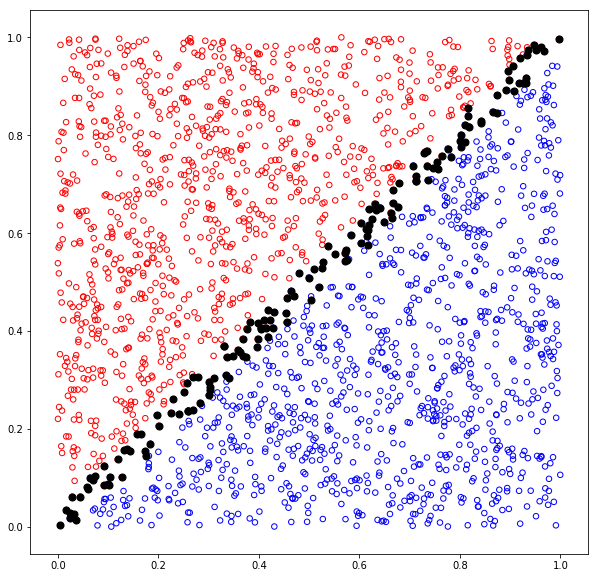

In [9]:
def sv_graph():
    support_vectors = X[S]

    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(1, 1)
    ax = fig.add_subplot(gs[0, 0])
    ax.scatter(X[:,0], X[:,1], edgecolors=['red' if y_i == -1 else 'blue' for y_i in y], facecolors='none', s=30)
    ax.scatter(support_vectors[:,0], support_vectors[:,1], c='black', s=50)
    plt.show()
    
sv_graph()

Interesting, right? What we are seeing here is the two categories identified by red and blue colors, respectively. The black points are the support vectors themselves. As you can see, these points are near the boundary and lie on the margin. In this case, a linear kernel works well for us because our dataset is linearly separable.

Now let's generate a non-linearly separable toy dataset. 

In [0]:
X, y = generate_data(DATASET_CIRCULAR)

And train our model on this new dataset by using a RBF kernel

In [18]:
svm_parameters = train_svm(KERNEL_RBF)

     pcost       dcost       gap    pres   dres
 0:  2.9502e+05 -1.3880e+07  3e+07  6e-01  1e-12
 1:  6.1233e+05 -2.8999e+06  4e+06  5e-14  1e-12
 2:  1.2508e+05 -3.4425e+05  5e+05  5e-13  7e-13
 3:  1.1832e+04 -8.6550e+04  1e+05  4e-13  6e-13
 4: -3.9805e+03 -5.9435e+04  6e+04  5e-13  6e-13
 5: -1.0589e+04 -4.6149e+04  4e+04  2e-13  7e-13
 6: -1.3158e+04 -4.1426e+04  3e+04  6e-13  7e-13
 7: -1.5574e+04 -3.6909e+04  2e+04  5e-13  7e-13
 8: -1.6990e+04 -3.4348e+04  2e+04  5e-13  7e-13
 9: -1.8563e+04 -3.1380e+04  1e+04  2e-12  8e-13
10: -1.9736e+04 -2.9523e+04  1e+04  4e-13  8e-13
11: -2.0516e+04 -2.8187e+04  8e+03  1e-12  7e-13
12: -2.1188e+04 -2.7028e+04  6e+03  2e-13  8e-13
13: -2.1579e+04 -2.6422e+04  5e+03  8e-14  8e-13
14: -2.2048e+04 -2.5663e+04  4e+03  8e-13  8e-13
15: -2.2563e+04 -2.4826e+04  2e+03  2e-13  8e-13
16: -2.2868e+04 -2.4357e+04  1e+03  1e-12  7e-13
17: -2.3153e+04 -2.3941e+04  8e+02  5e-15  8e-13
18: -2.3324e+04 -2.3722e+04  4e+02  5e-13  7e-13
19: -2.3418e+04 -2.36

Let's obtain the parameters of our new SVM

In [19]:
alphas = np.array(svm_parameters['x'])[:, 0]
w, b, S = get_parameters(alphas)

print('Alphas:', alphas[S][0:20])
print('w and b', w, b)

Alphas: [100.         100.          64.37669681 100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.        ]
w and b [ 1.38055783 -0.1857455 ] -0.5853943801061152


And see a graph of our data distribution, including the support vectors

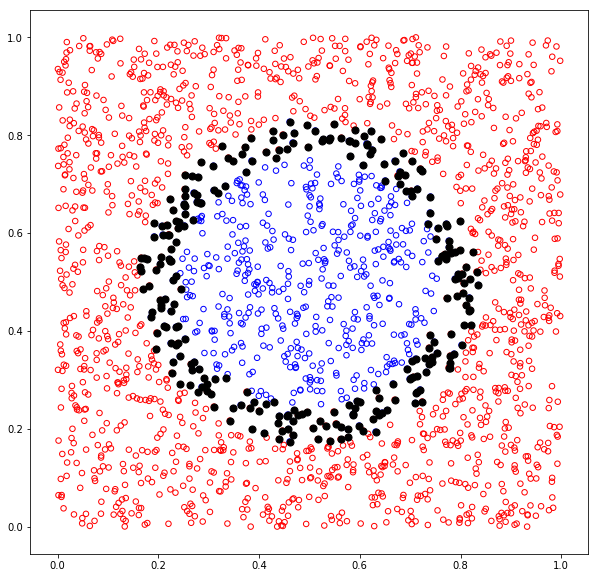

In [20]:
sv_graph()

By using the RBF, what we did here was to convert this naturally non-linearly separable space into a linearly-separable one by using the kernel trick. We wouldn't have been able to classify the points if we hadn't used such a kernel.

I hope you enjoyed this exercise! I highly encourage you to try and use your own datasets as well as play around with the hyperparameters. Let me know about your findings.

Enjoy!